In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyart.graph.cm as pcm
import matplotlib.colors as colors
from matplotlib import dates
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.interpolate as interpolate
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats.mstats import scoreatpercentile
import pyart
import os,subprocess,time,copy
import random
import scipy
import math
import matplotlib.gridspec as gridspec
import cPickle as pickle
#import pickle
import pprint
import pyproj
import pandas as pd
import scipy.interpolate as interpolate
import sharppy.sharptab as tab
import pymc
import corner
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level
%matplotlib inline

# Testing DSD prior distributions
This has been copied from icepro_spectra_mcmc_cp5, but will only use bits and pieces of that code. 

The main focus of this code is to test what priors may look like for cloud DSD parameters, and/or for observeable quantities. Let's review what the hell we're talking about. The cloud DSD parameters are N0, D0, and $\alpha$, assuming a gamma distribution that looks like:

$$ n(D) = N_0\left( \frac{D}{D_0}\right)^\alpha e^{-D/D_0} $$

We may also be sampling from the space of observable quantities $N_T$, LWC, and effective radius, which are given by the zeroth moment, third moment, ratio of the third and second moments, respectively. Auf der Maur 2001 provides a generalized gamma function, and I think our findings here are in agreement, basically. The k-th moment of a so-described gamma function is given by...

$$ M_k = N_0 D_0^{k+1}\Gamma(\alpha+k+1) $$

So very simply, let's sample and see what happens.

## First, sample from a uniform prior in N0, D0, $\alpha$ :

In [40]:
N0_min = 1.e-4   #..cm   Posselt and Mace, 2014
N0_max = 1.e-2   #..cm 
N0_mean= 5.e-4
#..
D0_min = 1.e-3   #..cm-4
D0_max = 1.e7    #..cm-4
D0_mean= 5.e3
#..
al_min = 0.
al_max = 1.0
al_mean= 0.

In [41]:
N0 = pymc.Uniform(name='N0', lower=N0_min, upper=N0_max)
D0 = pymc.Uniform(name='D0', lower=N0_min, upper=N0_max)
al = pymc.Uniform(name='alpha', lower=al_min, upper=al_max)

mc     = pymc.MCMC([N0,D0,al])
mc.sample(10000)


 [-----------------100%-----------------] 10000 of 10000 complete in 0.8 sec

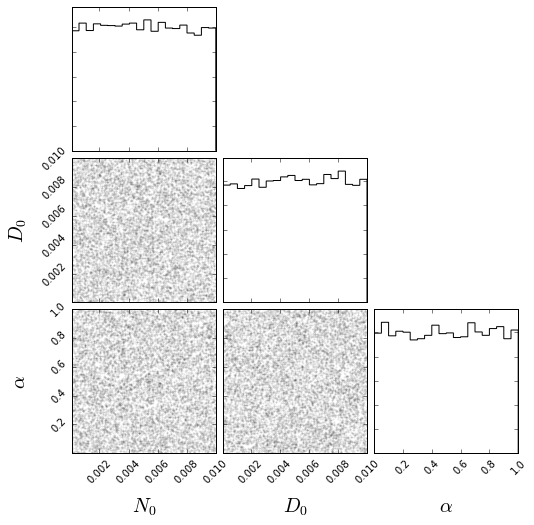

In [42]:
par_labels = [r'$N_0$',r'$D_0$',r'$\alpha$']
label_kwargs = {'fontsize':'20'}
samples = np.vstack((mc.trace('N0')[:], mc.trace('D0')[:],mc.trace('alpha')[:]))
fig,axes = corner.corner(samples.T,labels=par_labels,plot_density=False,plot_contours=False,
                         label_kwargs=label_kwargs)
#fig,axes = corner.corner(samples.T,labels=par_labels)
#..

## Now, see what this looks like in the space of M0, M3, and M3/M2
These correspond to $N_T$, LWC, and $R_{eff}$, respectively.

In [43]:
M0 = mc.trace('N0')[:]*mc.trace('D0')[:]*scipy.special.gamma(mc.trace('alpha')[:]+1.)
M2 = mc.trace('N0')[:]*mc.trace('D0')[:]**3 *scipy.special.gamma(mc.trace('alpha')[:]+3.)
M3 = mc.trace('N0')[:]*mc.trace('D0')[:]**4 *scipy.special.gamma(mc.trace('alpha')[:]+4.)
Re = M3/M2
#..

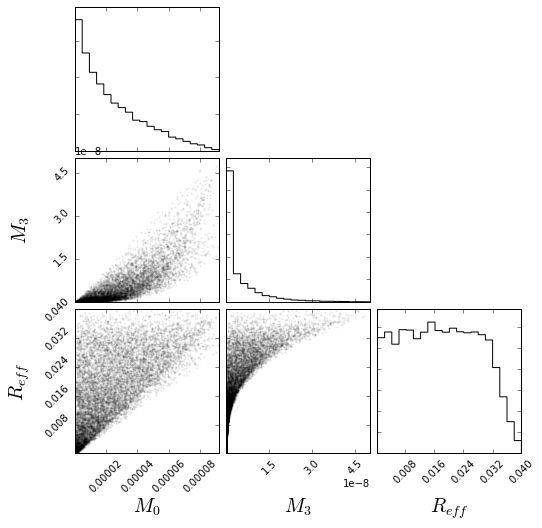

In [44]:
par_labels = [r'$M_0$',r'$M_3$',r'$R_{eff}$']
samples = np.vstack((M0, M2,Re))
label_kwargs = {'fontsize':'20'}
fig,axes = corner.corner(samples.T,labels=par_labels,plot_density=False,plot_contours=False,
                        label_kwargs=label_kwargs)
#fig,axes = corner.corner(samples.T,labels=par_labels)

## Now look at the respective range of parameters given a different formulation of the gamma size distribution
Namely, if we write the gamma size distribution (as is commonly done, see Ulbrich 1983, for example) as follows:
$$ N(D) = N_0  D^\mu  e^{-\lambda D} $$
What is the corresponding distribution of $N_0$, $\mu$, and $\lambda$?

In [45]:
N0_alt = mc.trace('N0')[:]/(mc.trace('D0')[:]**mc.trace('alpha')[:])
lam_alt = 1./mc.trace('D0')[:]
mu_alt = mc.trace('alpha')[:]
#..

(0.0, 800.0)

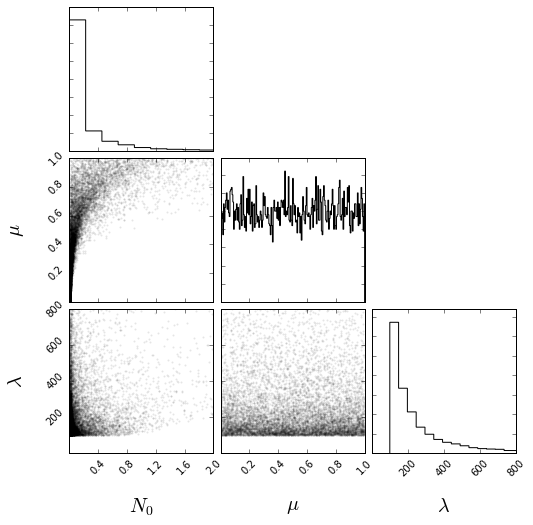

In [46]:
par_labels = [r'$N_0$',r'$\mu$',r'$\lambda$']
samples = np.vstack((N0_alt, mu_alt, lam_alt))
fig,axes = corner.corner(samples.T,labels=par_labels,plot_density=False,plot_contours=False,
                        label_kwargs=label_kwargs,bins=200)
#..
xmax0 = 2.
axes[0,0].set_xlim(0,xmax0)
axes[1,0].set_xlim(0,xmax0)
axes[2,0].set_xlim(0,xmax0)
#..
ymax2 = 800.
axes[2,0].set_ylim(0.,ymax2)
axes[2,1].set_ylim(0.,ymax2)
axes[2,2].set_xlim(0.,ymax2)

### Now try with $N_0$ in log space

(0.0, 800.0)

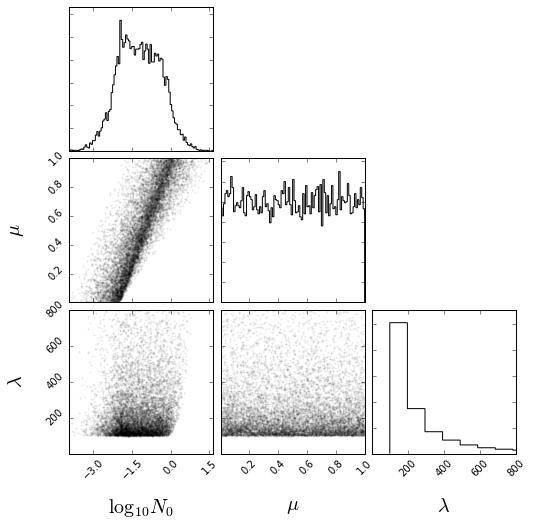

In [47]:
par_labels = [r'$\log_{10}N_0$',r'$\mu$',r'$\lambda$']
samples = np.vstack((np.log10(N0_alt), mu_alt, lam_alt))
fig,axes = corner.corner(samples.T,labels=par_labels,plot_density=False,plot_contours=False,
                        label_kwargs=label_kwargs,bins=100)
#..
# xmax0 = 2.
# axes[0,0].set_xlim(0,xmax0)
# axes[1,0].set_xlim(0,xmax0)
# axes[2,0].set_xlim(0,xmax0)
#..
ymax2 = 800.
axes[2,0].set_ylim(0.,ymax2)
axes[2,1].set_ylim(0.,ymax2)
axes[2,2].set_xlim(0.,ymax2)

## Now, start over and sample from the space of $\log_{10}N_0$, $D_0$, and $\alpha$

In [48]:
logN0 = pymc.Uniform(name='logN0', lower=np.log10(N0_min), upper=np.log10(N0_max))
D0 = pymc.Uniform(name='D0', lower=N0_min, upper=N0_max)
al = pymc.Uniform(name='alpha', lower=al_min, upper=al_max)

mc     = pymc.MCMC([logN0,D0,al])
mc.sample(10000)


 [-----------------100%-----------------] 10000 of 10000 complete in 0.8 sec

In [49]:
M0 = 10.**mc.trace('logN0')[:]*mc.trace('D0')[:]*scipy.special.gamma(mc.trace('alpha')[:]+1.)
M2 = 10.**mc.trace('logN0')[:]*mc.trace('D0')[:]**3 *scipy.special.gamma(mc.trace('alpha')[:]+3.)
M3 = 10.**mc.trace('logN0')[:]*mc.trace('D0')[:]**4 *scipy.special.gamma(mc.trace('alpha')[:]+4.)
Re = M3/M2
#..

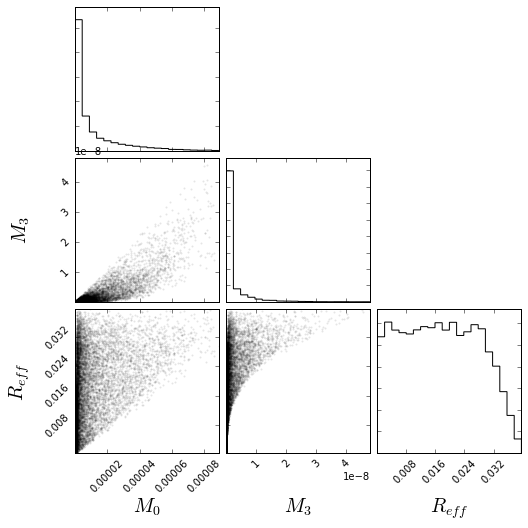

In [50]:
par_labels = [r'$M_0$',r'$M_3$',r'$R_{eff}$']
samples = np.vstack((M0, M2,Re))
label_kwargs = {'fontsize':'20'}
fig,axes = corner.corner(samples.T,labels=par_labels,plot_density=False,plot_contours=False,
                        label_kwargs=label_kwargs)

In [51]:
N0_alt = 10.**mc.trace('logN0')[:]/(mc.trace('D0')[:]**mc.trace('alpha')[:])
lam_alt = 1./mc.trace('D0')[:]
mu_alt = mc.trace('alpha')[:]
#..

(0.0, 800.0)

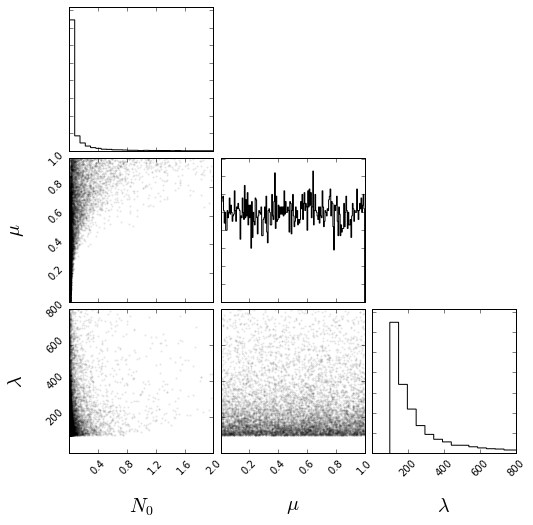

In [52]:
par_labels = [r'$N_0$',r'$\mu$',r'$\lambda$']
samples = np.vstack((N0_alt, mu_alt, lam_alt))
fig,axes = corner.corner(samples.T,labels=par_labels,plot_density=False,plot_contours=False,
                        label_kwargs=label_kwargs,bins=200)
#..
xmax0 = 2.
axes[0,0].set_xlim(0,xmax0)
axes[1,0].set_xlim(0,xmax0)
axes[2,0].set_xlim(0,xmax0)
#..
ymax2 = 800.
axes[2,0].set_ylim(0.,ymax2)
axes[2,1].set_ylim(0.,ymax2)
axes[2,2].set_xlim(0.,ymax2)

(0.0, 800.0)

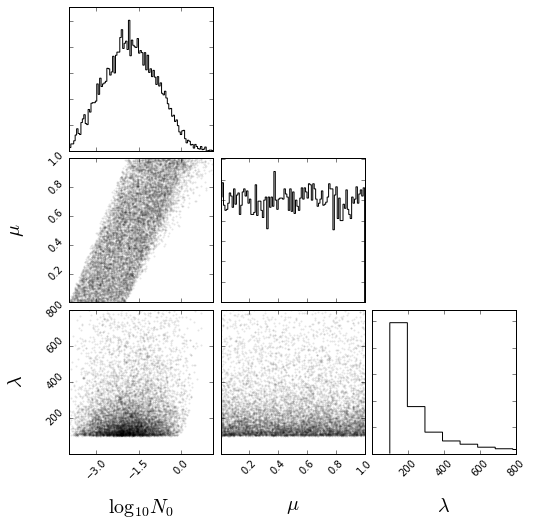

In [53]:
par_labels = [r'$\log_{10}N_0$',r'$\mu$',r'$\lambda$']
samples = np.vstack((np.log10(N0_alt), mu_alt, lam_alt))
fig,axes = corner.corner(samples.T,labels=par_labels,plot_density=False,plot_contours=False,
                        label_kwargs=label_kwargs,bins=100)
#..
# xmax0 = 2.
# axes[0,0].set_xlim(0,xmax0)
# axes[1,0].set_xlim(0,xmax0)
# axes[2,0].set_xlim(0,xmax0)
#..
ymax2 = 800.
axes[2,0].set_ylim(0.,ymax2)
axes[2,1].set_ylim(0.,ymax2)
axes[2,2].set_xlim(0.,ymax2)

## Now, sample from space of $\log_{10}N_0$, $\mu$, and $\lambda$ -- the other gamma PSD form
We know that parameters are correlated in this space. Let's make some assumptions about how they're correlated and go from there.